In [1]:
# import packages
import os
from glob import glob
import geopandas as gpd
from pathlib import Path
from typing import List, Union
from osgeo import gdal, gdal_array
import numpy as np
import matplotlib.pyplot as plt
import rioxarray
import xarray as xr
import rasterio as rio
import datetime
from datetime import datetime, timedelta
import sys
import pandas as pd
import seaborn as sns
from scipy.stats import linregress

In [2]:
# set up paths, directories, and variables for this specific dam
data_path = '/home/jovyan/repos/fufiters_imja_analysis/data'
asc_burst = '012_023790_IW1'
des_burst = '121_258661_IW2'
asc_burst_path = f'{data_path}/data_igrams/{asc_burst}'
des_burst_path = f'{data_path}/data_igrams/{des_burst}'

dam_name = 'imja'
proc_path = f'/home/jovyan/repos/fufiters_imja_analysis/analysis'

# define reference point, [y, x]
reference_point = [3086715.2, 491092.4]

# define crs 
crs = 32645

In [3]:
# read in dam polygon
dam_fn = f'../mapping/polygons/{dam_name}_md.shp'
dam_gdf = gpd.read_file(dam_fn)
dam_gdf = dam_gdf.to_crs(crs) # reproject in case of mistake

# load in moving area polygon
moving_fn = f'../mapping/polygons/{dam_name}_moving.shp'
moving_gdf = gpd.read_file(moving_fn)

# load in moving area polygon
reference_fn = f'../mapping/polygons/{dam_name}_reference.shp'
reference_gdf = gpd.read_file(reference_fn)

# load in stable area polygon
stable_fn = f'../mapping/polygons/{dam_name}_stable.shp'
stable_gdf = gpd.read_file(stable_fn).to_crs(crs)

# load in water mask
water_fn = f'../mapping/polygons/water_mask.shp'
water_gdf = gpd.read_file(water_fn).to_crs(crs)

# pad dam bounds by 5 km 
padding = 5000
aoi_extent = [dam_gdf.bounds.minx.item()-padding,
               dam_gdf.bounds.maxy.item()+padding,
               dam_gdf.bounds.maxx.item()+padding,
               dam_gdf.bounds.miny.item()-padding]

In [4]:
vertical_fn = './vertical_velocity_imja.tif'
vertical_veloc_da = rioxarray.open_rasterio(vertical_fn).squeeze()

In [5]:
dem_fn = '../data/data_igrams/012_023790_IW1/20170123_20170204/S1_023790_IW1_20170123_20170204_VV_INT20_FFTS/S1_023790_IW1_20170123_20170204_VV_INT20_FFTS_dem_imja.tif'
dem_da = rioxarray.open_rasterio(dem_fn).squeeze()
elev_above_lake = dem_da-4961

In [6]:
elev_above_lake = elev_above_lake.rio.reproject_match(vertical_veloc_da)

In [7]:
#elev_above_lake = elev_above_lake.where(elev_above_lake >= 0)
vertical_veloc_da = vertical_veloc_da.where(vertical_veloc_da <= 0)

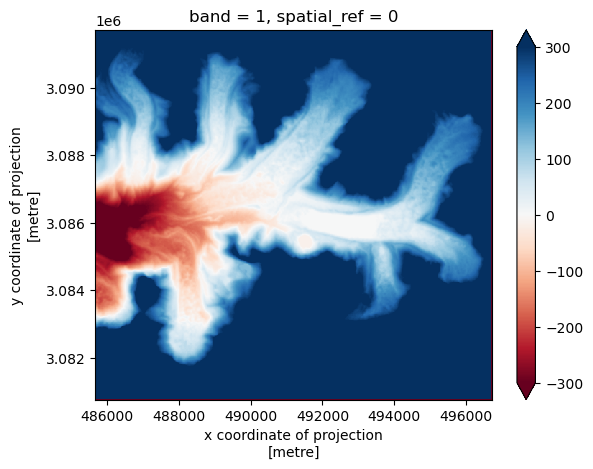

In [8]:
elev_above_lake.plot(vmin=-300, vmax=300, cmap='RdBu')

In [9]:
years_until_lake_level = elev_above_lake/(vertical_veloc_da*-1)
# adjust to relative to 2024 based on 2013 DEM timestamp (real timestamp 2011-2015)
years_until_lake_level = years_until_lake_level - 11
# mask areas moving upward
years_until_lake_level = years_until_lake_level.where(vertical_veloc_da <= 0)
# mask areas already below lake level
years_until_lake_level = years_until_lake_level.where(elev_above_lake >= 0)

<Axes: title={'center': 'band = 1, spatial_ref = 0'}, xlabel='x coordinate of projection\n[metre]', ylabel='y coordinate of projection\n[metre]'>

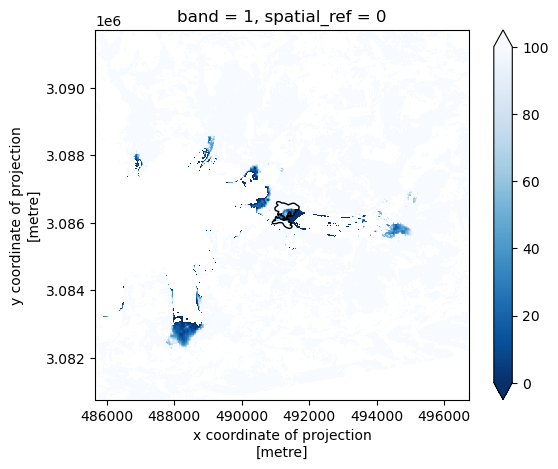

In [10]:
f, ax = plt.subplots()
years_until_lake_level.plot(ax=ax, vmin=0, vmax=100, cmap='Blues_r')
moving_gdf.plot(ax=ax, edgecolor='black', facecolor='none')

In [11]:
years_clipped = years_until_lake_level.rio.clip(moving_gdf.geometry, crs=moving_gdf.crs, drop=True)

In [16]:
years_clipped.where(years_clipped <= 100).count()

<xarray.DataArray ()> Size: 8B
array(307)
Coordinates:
    band         int64 8B 1
    spatial_ref  int64 8B 0

In [15]:
years_until_lake_level.rio.clip(moving_gdf.geometry, crs=moving_gdf.crs, drop=True).count(dim=['x', 'y'])

<xarray.DataArray ()> Size: 8B
array(746)
Coordinates:
    band         int64 8B 1
    spatial_ref  int64 8B 0

In [14]:
years_until_lake_level.rio.to_raster('imja_years_until_lake_level.tif')